In [2]:
import sys
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import collections
from tqdm import tqdm_notebook

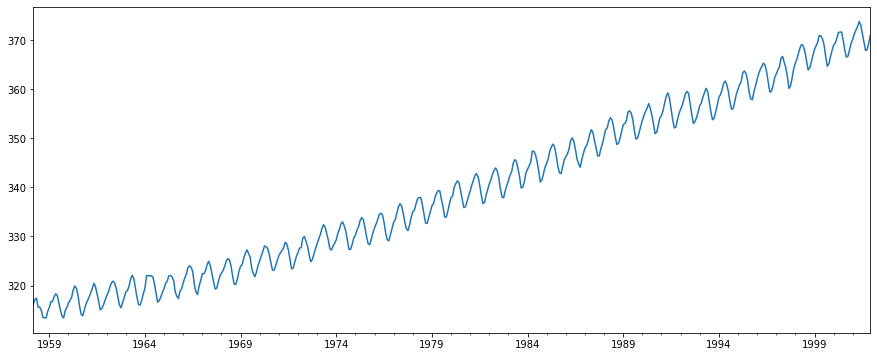

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))
plt.show()

In [4]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [5]:
warnings.filterwarnings("ignore") # отключает предупреждения
#saving results
aic_result = 999999
order_ = tuple
seasonal_order_ = tuple
#gridsearch
for param in tqdm_notebook(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < aic_result:
                aic_result = results.aic
                order_ = param
                seasonal_order_ = param_seasonal

            # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(f'Best results: aic: {aic_result}, order: {order_}, seasonal order: {seasonal_order_}')

  0%|          | 0/8 [00:00<?, ?it/s]

Best results: aic: 277.78021998671136, order: (1, 1, 1), seasonal order: (1, 1, 1, 12)


In [6]:
mod = sm.tsa.statespace.SARIMAX(y,
order=order_,
seasonal_order=seasonal_order_,
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


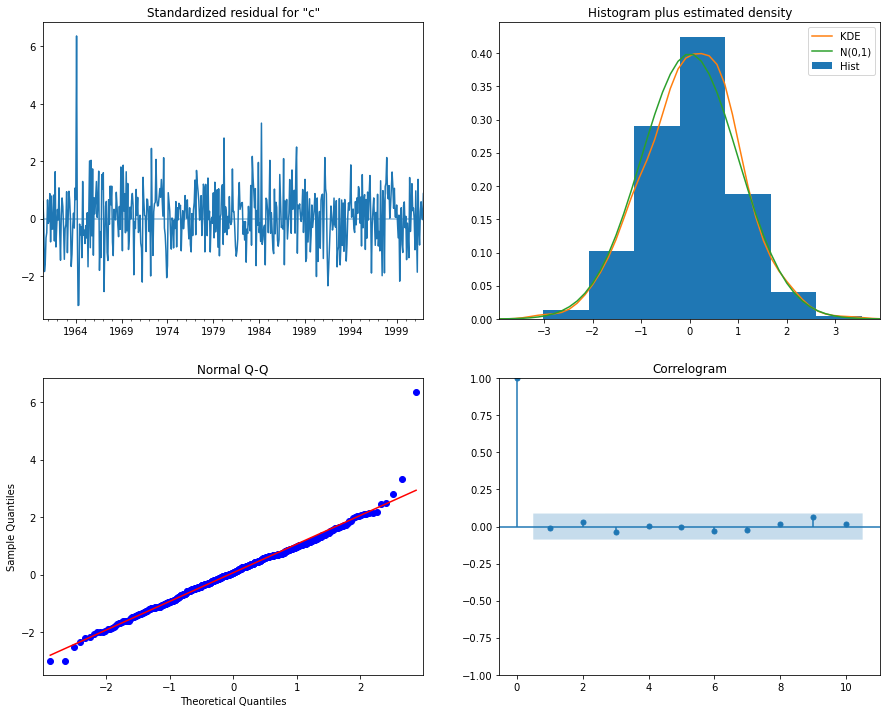

In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [8]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

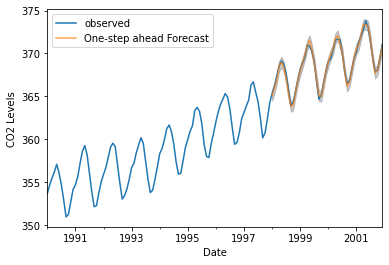

In [9]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [10]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':] # Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [11]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

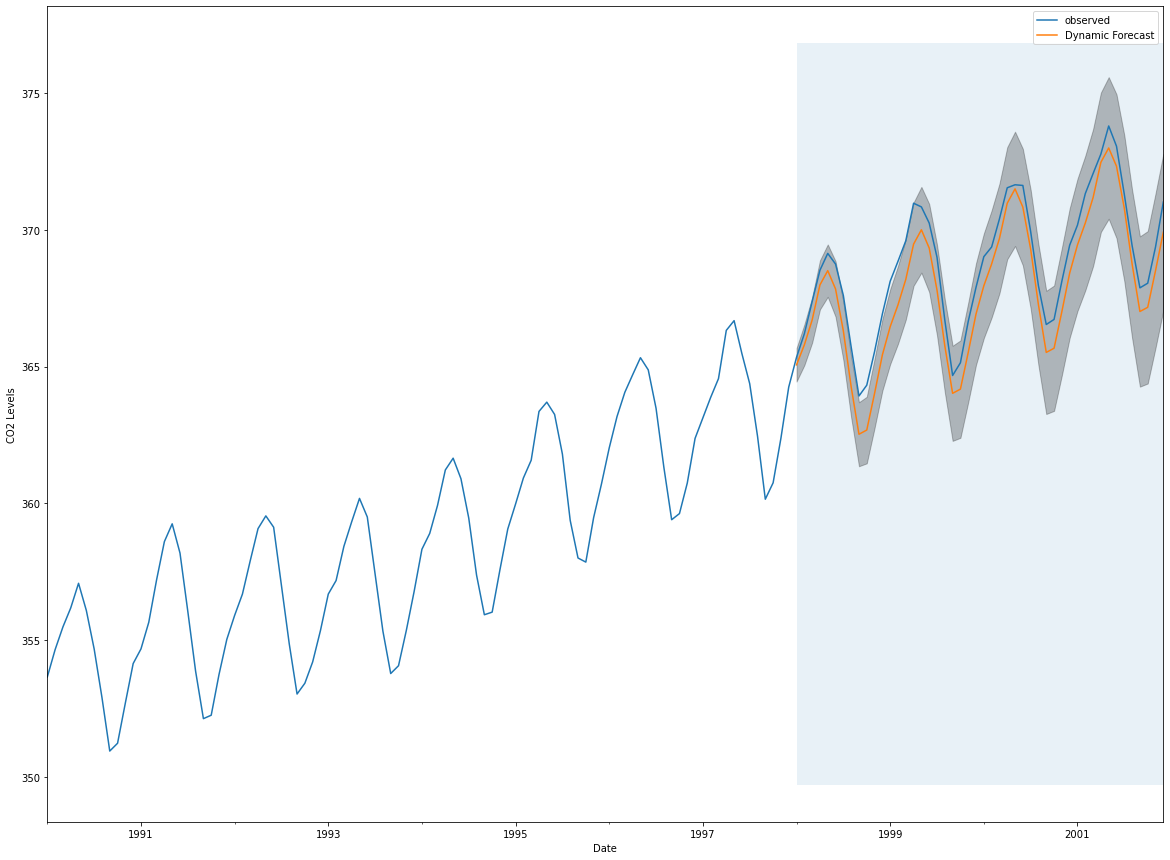

In [12]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [13]:
# Извлечь прогнозируемые и истинные значения временного ряда
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':] 
# Вычислить среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [14]:
# Получить прогноз на 500 шагов вперёд
pred_uc = results.get_forecast(steps=500)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

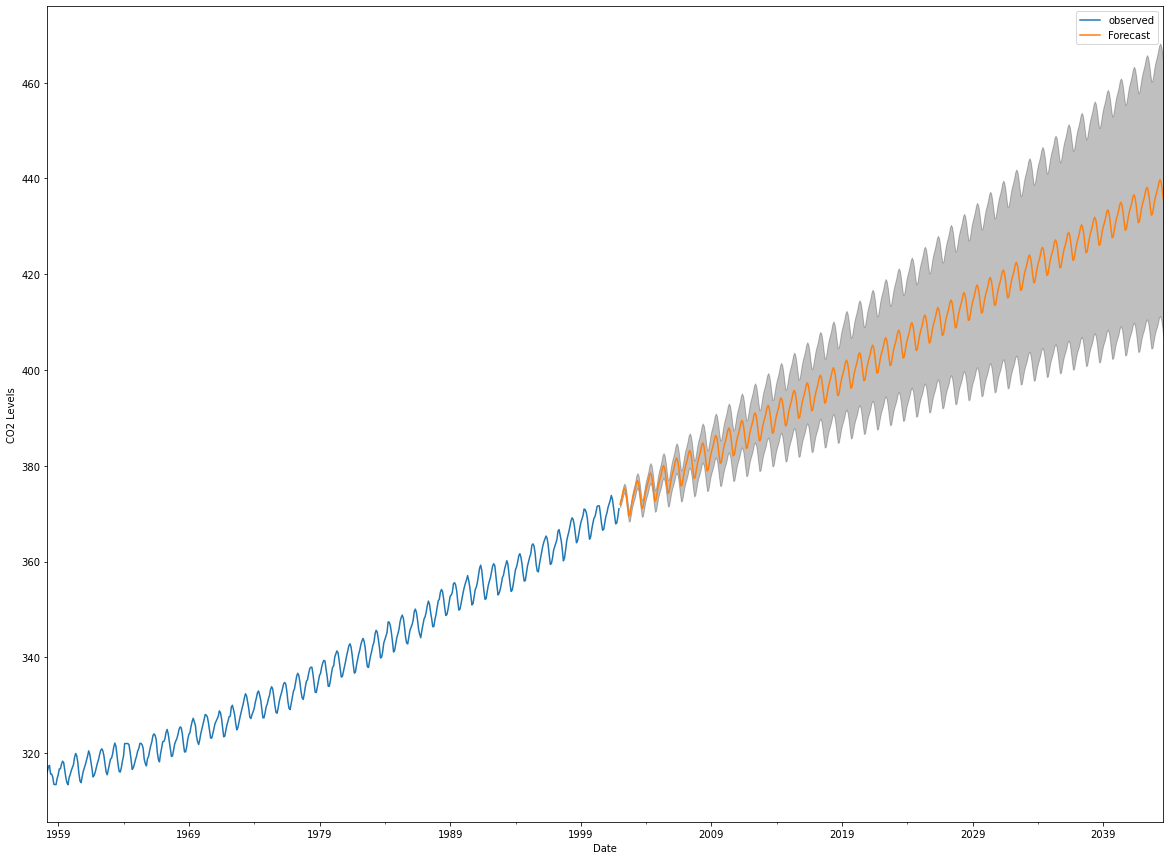

In [15]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()